In [1]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from shapely.ops import unary_union

sys.path.append("..")
import geoobb.obb as obb

## Load Data


In [2]:
gdf = gpd.read_file(r'../data/bk_parcels.shp')
gdf['BBL'] = gdf.BBL.astype(str)
gdf.to_crs(epsg=2263, inplace=True)

# the api has a max record limit of 4000
print(f'{len(gdf)} records returned')


276060 records returned


## Generate OBBs


In [3]:
convex_hull_arrs = gdf.geometry.convex_hull.map(obb.geom_to_array)
obbs = convex_hull_arrs.apply(obb.oriented_bounding_box)

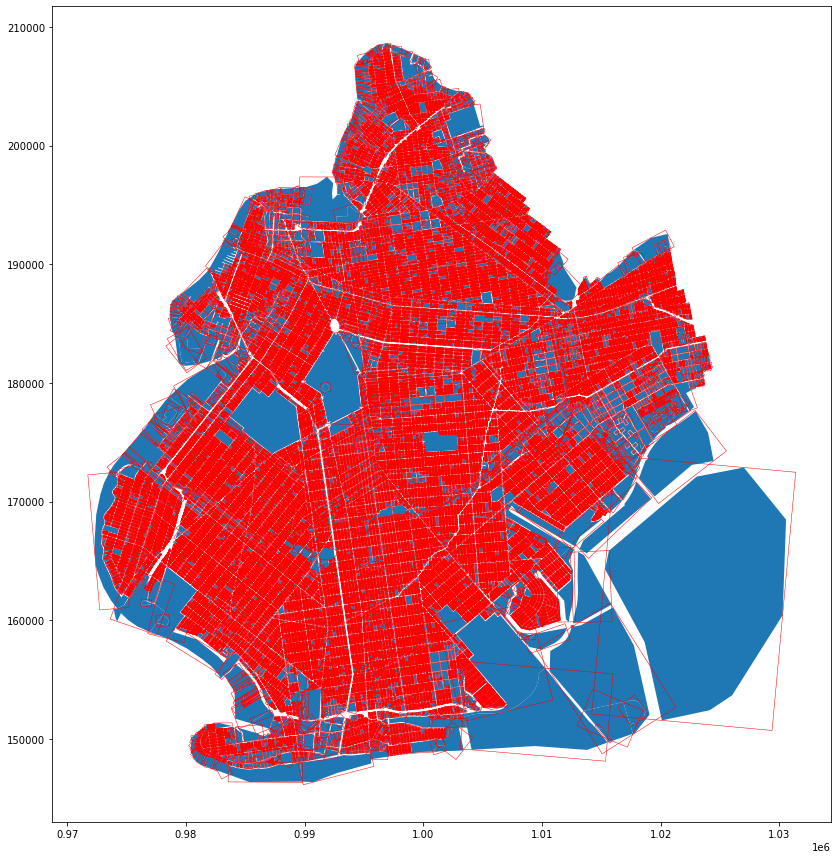

In [4]:
obbs_gs = gpd.GeoSeries(obbs.map(obb.polygon_from_obb), crs=gdf.crs)
ax = gdf.plot(figsize=(15, 15))
obbs_gs.plot(ax=ax, linewidth=.5, edgecolor='red', facecolor='none');

## Block Orientation KMeans Elbow Analysis


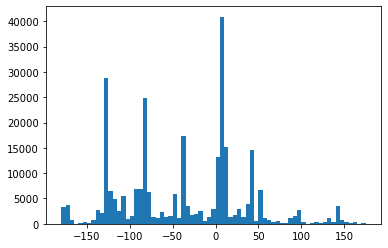

In [5]:
angles = np.array([obb.obb_angle(o) for o in obbs])
plt.hist(np.degrees(angles), bins=np.arange(-180, 180, 5));

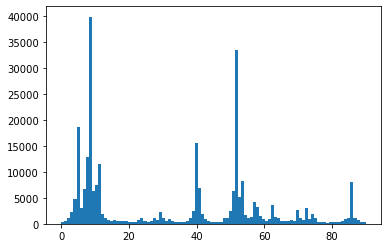

In [6]:
plt.hist(np.degrees(angles) % 90, bins=100);

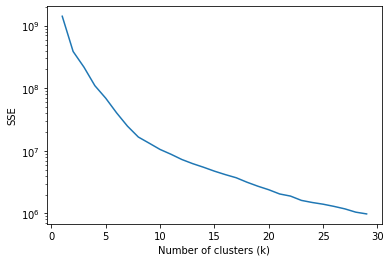

In [7]:
data = np.degrees(angles).reshape(-1, 1)

sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.yscale('log')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

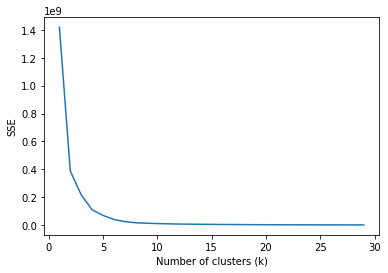

In [8]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

In [19]:
optimal_k = 13 # strong fit - bit beyond elbow

kmeans = KMeans(n_clusters=optimal_k, max_iter=1000)
kmeans.fit(data)

print('Centers: ', kmeans.cluster_centers_)

gdf['cluster'] = kmeans.labels_

Centers:  [[ -36.41971367]
 [-111.40514838]
 [  54.86916279]
 [   8.22873938]
 [ 143.9603546 ]
 [ -81.50422658]
 [-172.67947694]
 [  37.67697226]
 [-128.54353223]
 [  95.85233049]
 [ -94.30421882]
 [ -54.23620792]
 [ -12.63119027]]


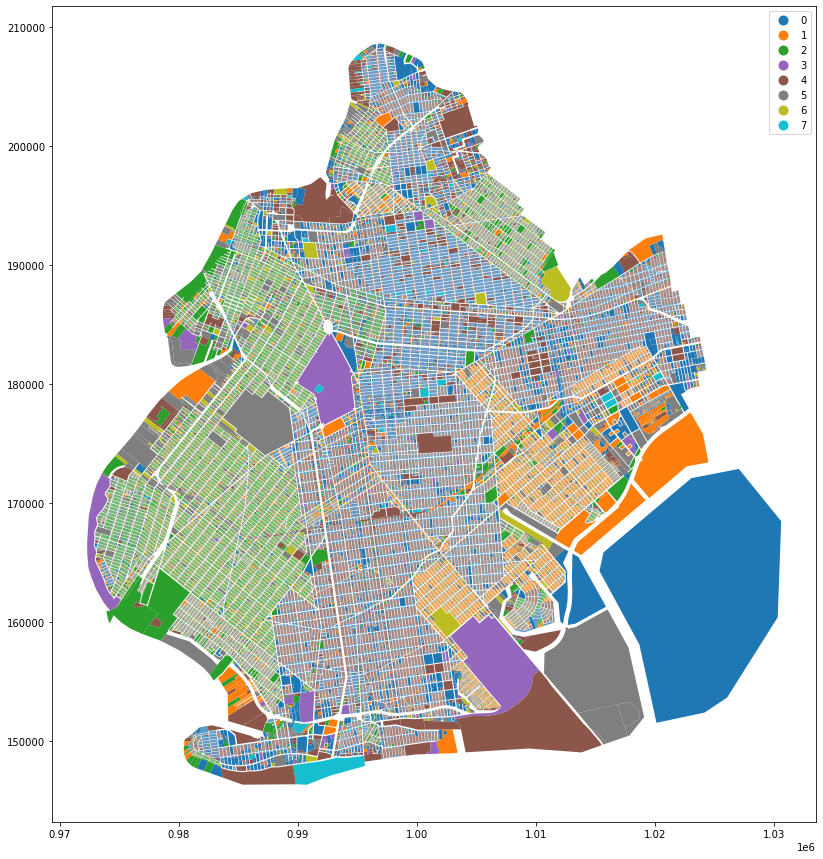

In [10]:
gdf.plot(column='cluster', figsize=(15, 15), legend=True, categorical=True);

## With Distance Threshold


In [28]:
distance_threshold = 16 # degrees

distances_to_center = np.min(distance.cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)
labels = np.where(distances_to_center > distance_threshold, optimal_k, kmeans.labels_)

In [29]:
gdf['cluster_w_dist_threshold'] = labels

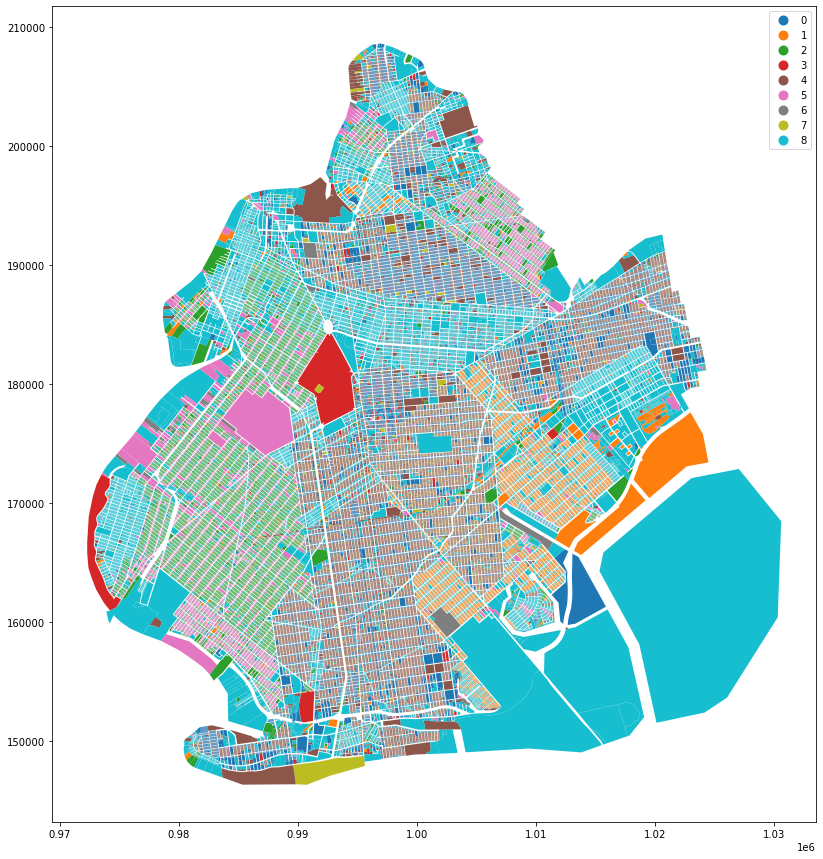

In [13]:
gdf.plot(column='cluster_w_dist_threshold', figsize=(15, 15), legend=True, categorical=True);

## By Tax Block


In [22]:
gdf['tax_block'] = gdf['BBL'].str.slice(1, 6)

In [30]:
# Get most frequent cluster for each tax block
block_cluster = pd.DataFrame(
    gdf.groupby('tax_block')['cluster_w_dist_threshold'].agg(
        block_cluster=lambda x: pd.Series.mode(x)[0])).join(
            gdf.groupby('tax_block').geometry.agg(unary_union)).reset_index()

In [31]:
block_cluster = gpd.GeoDataFrame(block_cluster, geometry='geometry', crs=gdf.crs)

In [32]:
map_labels = {ix: f'{int(deg[0])} +- {distance_threshold} degrees' for ix, deg in enumerate(kmeans.cluster_centers_)}
map_labels[len(kmeans.cluster_centers_)] = 'Outlier'

In [33]:
block_cluster['block_cluster_label'] = block_cluster['block_cluster'].map(map_labels)

block_cluster['block_cluster_label'].value_counts()

8 +- 16 degrees       2452
-128 +- 16 degrees    1149
-81 +- 16 degrees     1042
37 +- 16 degrees       743
-36 +- 16 degrees      732
-111 +- 16 degrees     531
-54 +- 16 degrees      327
-94 +- 16 degrees      301
-12 +- 16 degrees      239
143 +- 16 degrees       30
54 +- 16 degrees        20
95 +- 16 degrees        19
Outlier                 11
-172 +- 16 degrees       9
Name: block_cluster_label, dtype: int64

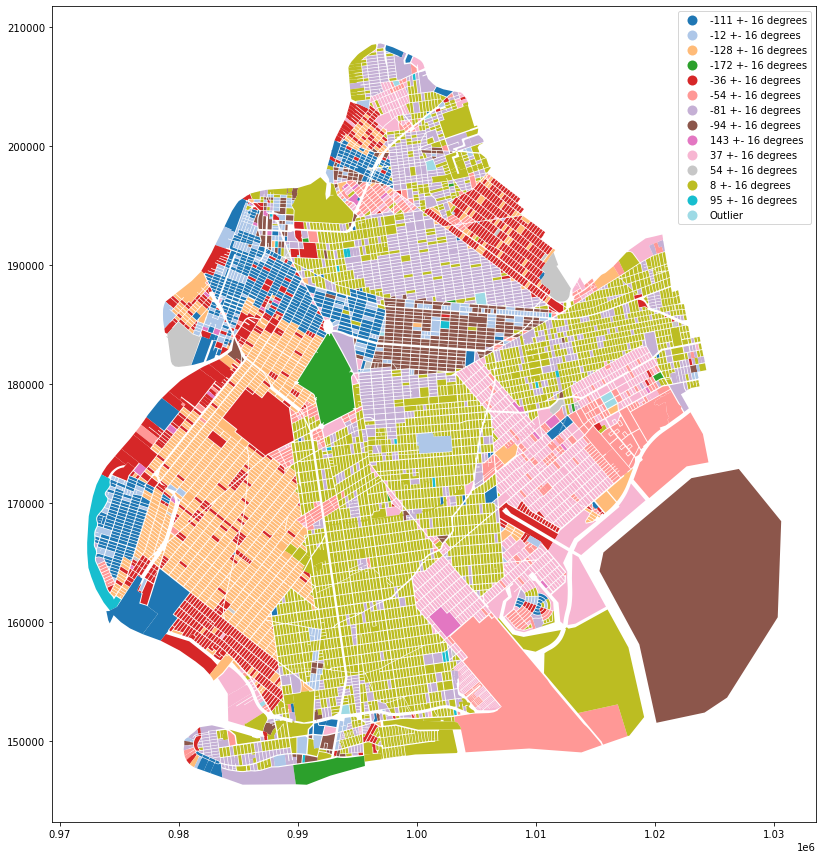

In [34]:
block_cluster.plot(column='block_cluster_label', figsize=(15, 15), legend=True, categorical=True, cmap='tab20');